In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

In [2]:
import numpy as np
import glob
from os.path import dirname, join as pjoin
import scipy.io as sio
import pdb
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [4]:
N_dataset = 21   # the number of worms
N_cell = 189     # the number of neurons
T = 960          # the number of time steps
N_length = 109
odor_channels = 3
T_start = 160
trace_datasets = np.zeros((N_dataset, N_cell, T))
odor_datasets = np.zeros((N_dataset, odor_channels, T))
name_list = []

# .mat data load
basepath = '../../data/'
mat_fname = pjoin(basepath, 'all_traces_Heads_new.mat')
trace_variable = sio.loadmat(mat_fname)
#trace_arr = trace_variable['norm_traces']
trace_arr = trace_variable['traces']
is_L = trace_variable['is_L']
neurons_name = trace_variable['neurons']
stim_names = trace_variable["stim_names"]
stimulate_seconds = trace_variable['stim_times']
stims = trace_variable['stims']
# multiple trace datasets concatnate
for idata in range(N_dataset):
    ineuron = 0
    for ifile in range(N_length):
        if trace_arr[ifile][0].shape[1] == 42:
            data = trace_arr[ifile][0][0][idata]
            if data.shape[0] < 1:
                trace_datasets[idata][ineuron][:] = np.nan
            else:
                trace_datasets[idata][ineuron][0:data[0].shape[0]] = data[0]
            ineuron+= 1
            data = trace_arr[ifile][0][0][idata + 21]
            if data.shape[0] < 1:
                trace_datasets[idata][ineuron][:] = np.nan
            else:
                trace_datasets[idata][ineuron][0:data[0].shape[0]] = data[0]
            ineuron+= 1
        else:
            data = trace_arr[ifile][0][0][idata]
            if data.shape[0] < 1:
                trace_datasets[idata][ineuron][:] = np.nan
            else:
                trace_datasets[idata][ineuron][0:data[0].shape[0]] = data[0]
            ineuron+= 1

# neural activity target
activity_worms = trace_datasets[:,:, T_start:] + 2      # ********************
name_list = []
for ifile in range(N_length):
    if is_L[ifile][0][0].shape[0] == 42:
        name_list.append(neurons_name[ifile][0][0] + 'L')
        name_list.append(neurons_name[ifile][0][0] + 'R')
    else:
        name_list.append(neurons_name[ifile][0][0])
activity_list = name_list

step = 0.25
time = np.arange(start = 0, stop = T * step , step = step)
# odor list
odor_list = ['butanone','pentanedione','NaCL']
# multiple odor datasets concatnate
for idata in range(N_dataset):
    for it_stimu in range(stimulate_seconds.shape[0]):
        tim1_ind = time>stimulate_seconds[it_stimu][0]
        tim2_ind = time<stimulate_seconds[it_stimu][1]
        odor_on = np.multiply(tim1_ind.astype(np.int64),tim2_ind.astype(np.int64))
        stim_odor = stims[idata][it_stimu] - 1
        odor_datasets[idata][stim_odor][:] = odor_on
                
odor_worms = odor_datasets[:,:, T_start:]

In [5]:
print(odor_worms.shape)
print(activity_worms.shape)
print(len(activity_list))
print(activity_list[0:10])

(21, 3, 800)
(21, 189, 800)
189
['ADAL', 'ADAR', 'ADEL', 'ADER', 'ADFL', 'ADFR', 'ADLL', 'ADLR', 'AFDL', 'AFDR']


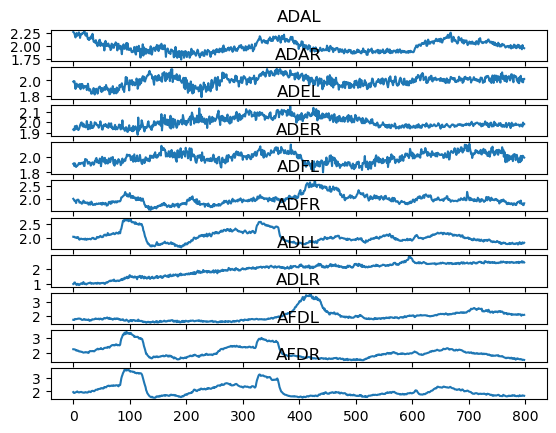

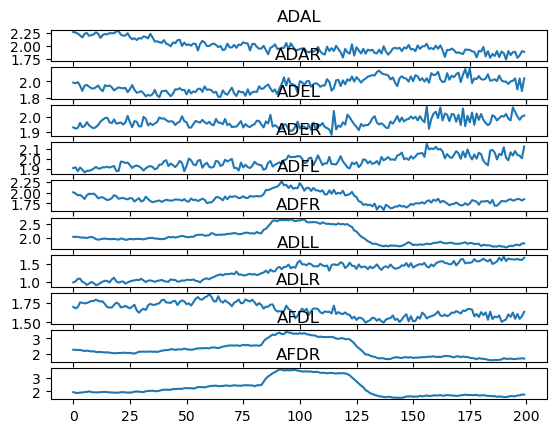

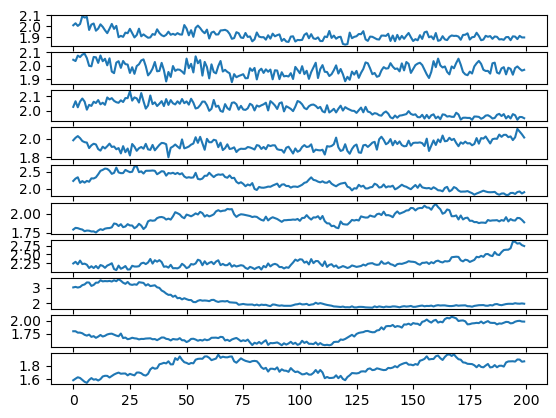

In [6]:
# Plot the first 10 neurons

for i in range(10):
    plt.subplot(10, 1, i+1)
    plt.plot(activity_worms[0][i])
    plt.title(activity_list[i])
plt.show()

for i in range(10):
    plt.subplot(10, 1, i+1)
    plt.plot(activity_worms[0][i][:200])
    plt.title(activity_list[i])
plt.show()

for i in range(10):
    plt.subplot(10, 1, i+1)
    plt.plot(activity_worms[0][i][400:600])
plt.show()

### Ground Truth Connectivity Matrix

In [7]:
# build a dictionary from index to neuron name
index_to_neuron = {}
for i in range(len(activity_list)):
    index_to_neuron[i] = activity_list[i]

# build a dictionary from neuron name to index
neuron_to_index = {}
for i in range(len(activity_list)):
    neuron_to_index[activity_list[i]] = i

In [20]:
connectivity_df = pd.read_csv('../../data/white_neuron_connect.csv', skipinitialspace = True)

connectivity_result_E = np.zeros((N_cell, N_cell))
connectivity_result_Chem = np.zeros((N_cell, N_cell))
# Loop through the rows of the connectivity df
for i in range(connectivity_df.shape[0]):
    if connectivity_df.iloc[i]['Type'] == 'EJ':
        # get the pre and post neuron names
        pre_neuron = connectivity_df.iloc[i]['Neuron 1']
        post_neuron = connectivity_df.iloc[i]['Neuron 2']
        if pre_neuron not in neuron_to_index or post_neuron not in neuron_to_index:
            continue
        # get the pre and post neuron indices
        pre_index = neuron_to_index[pre_neuron]
        post_index = neuron_to_index[post_neuron]
        # set the connectivity matrix
        connectivity_result_E[pre_index][post_index] = connectivity_df.iloc[i]['Nbr']

    elif connectivity_df.iloc[i]['Type'] == 'S' or connectivity_df.iloc[i]['Type'] == 'SP':
        pre_neuron = connectivity_df.iloc[i]['Neuron 2']
        post_neuron = connectivity_df.iloc[i]['Neuron 1']
        if pre_neuron not in neuron_to_index or post_neuron not in neuron_to_index:
            continue
        pre_index = neuron_to_index[pre_neuron]
        post_index = neuron_to_index[post_neuron]
        connectivity_result_Chem[pre_index][post_index] = connectivity_df.iloc[i]['Nbr']

    else:
        pre_neuron = connectivity_df.iloc[i]['Neuron 1']
        post_neuron = connectivity_df.iloc[i]['Neuron 2']
        if pre_neuron not in neuron_to_index or post_neuron not in neuron_to_index:
            continue
        pre_index = neuron_to_index[pre_neuron]
        post_index = neuron_to_index[post_neuron]
        connectivity_result_Chem[pre_index][post_index] = connectivity_df.iloc[i]['Nbr']


(189, 189)


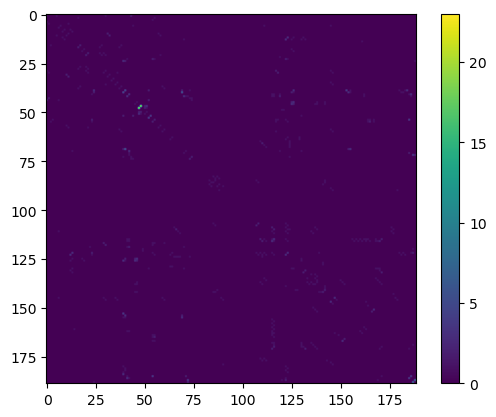

143


In [18]:
print(connectivity_result_E.shape)

plt.imshow(connectivity_result_E)
plt.colorbar()
plt.show()

# get the rank of the connectivity matrix
connectivity_rank = np.linalg.matrix_rank(connectivity_result_E)
print(connectivity_rank)

(189, 189)


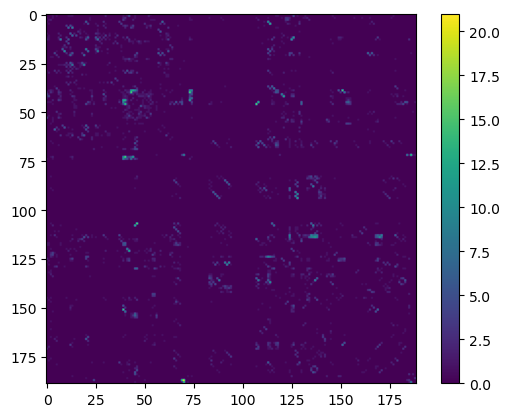

167


In [21]:
print(connectivity_result_Chem.shape)

plt.imshow(connectivity_result_Chem)
plt.colorbar()
plt.show()

# get the rank of the connectivity matrix
connectivity_rank = np.linalg.matrix_rank(connectivity_result_Chem)
print(connectivity_rank)